In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow as tf

## Generate our data given by the Lorenz equations

In [4]:
# Define the Lorenz system's derivative function
def lorenz_deriv(x_y_z, t0, sigma=10, beta=8/3, rho=28):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Generate data for a given rho value
def generate_data(rho, seed=123):
    dt = 0.01
    T = 8
    t = np.arange(0, T + dt, dt)

    np.random.seed(seed)
    x0 = -15 + 30 * np.random.random((100, 3))

    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])

    nn_input = np.zeros((100 * (len(t) - 1), 3))
    nn_output = np.zeros_like(nn_input)

    for j in range(100):
        nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
        nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

    return nn_input, nn_output


## Train a NN to advance the solution from t to t + ∆t for ρ = 10, 28 and 40 (Also define the training functions for LSTM, RNN).

In [21]:
# Train a Feed-Forward Neural Network
def train_ffnn(X_train, y_train, X_val, y_val, epochs=100):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(3,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    return model, history

# Train a Recurrent Neural Network
def train_rnn(X_train, y_train, X_val, y_val, epochs=100):
    model = Sequential()
    model.add(SimpleRNN(64, activation='tanh', input_shape=(1, 3), return_sequences=True))
    model.add(SimpleRNN(64, activation='tanh'))
    model.add(Dense(3))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Reshape the validation data
    X_val_rnn = X_val.reshape(-1, 1, 3)
    y_val_rnn = y_val.reshape(-1, 1, 3)
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val_rnn, y_val_rnn), verbose=0)

    return model, history


# Train a Long Short-Term Memory Network
def train_lstm(X_train, y_train, X_val, y_val, epochs=100):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(1, 3), return_sequences=True))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(3))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Reshape the validation data
    X_val_lstm = X_val.reshape(-1, 1, 3)
    y_val_lstm = y_val.reshape(-1, 1, 3)
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val_lstm, y_val_lstm), verbose=0)

    return model, history


In [14]:
# Generate training data for rho = 10, 28, 40
rho_values = [10, 28, 40]
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for rho in rho_values:
    X, y = generate_data(rho)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_combined = np.vstack(X_train_list)
y_train_combined = np.vstack(y_train_list)

X_train_combined = scaler.fit_transform(X_train_combined)
y_train_combined = scaler.fit_transform(y_train_combined)

# Train FFNN, RNN, LSTM, and ESN
X_train_rnn_lstm = X_train_combined.reshape(-1, 1, 3)
y_train_rnn_lstm = y_train_combined.reshape(-1, 1, 3)

ffnn_model, _ = train_ffnn(X_train_combined, y_train_combined, X_test_list[0], y_test_list[0])

## Now see how well NN works for future state prediction for ρ = 17 and ρ = 35.

In [15]:
# Test the models for rho = 17 and rho = 35
rho_test_values = [17, 35]
for rho in rho_test_values:
    X_test, y_test = generate_data(rho)

    X_test_scaled = scaler.transform(X_test)
    y_test_scaled = scaler.transform(y_test)
    X_test_rnn_lstm = X_test_scaled.reshape(-1, 1, 3)

    ffnn_pred = ffnn_model.predict(X_test_scaled)
    # Calculate Mean Squared Error (MSE) for each model
    ffnn_mse = np.mean((y_test_scaled - ffnn_pred)**2)

    print(f"Mean Squared Error for rho = {rho}")
    print(f"FFNN: {ffnn_mse}")

2500/2500 [==============================] - 2s 609us/step
Mean Squared Error for rho = 17
FFNN: 2.7239888884449422e-05
2500/2500 [==============================] - 1s 588us/step
Mean Squared Error for rho = 35
FFNN: 3.200739952980744e-05


2500/2500 [==============================] - 1s 584us/step


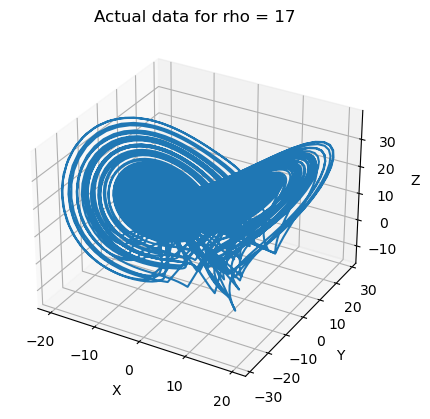

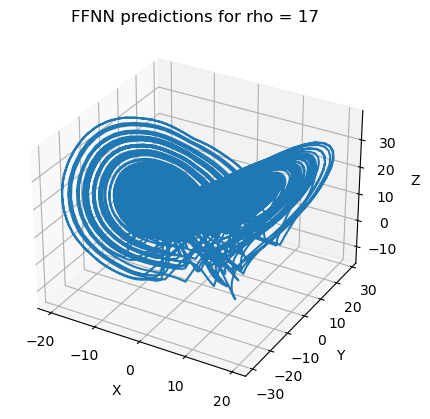

In [56]:
# Generate data for the original Lorenz equations
rho = 17
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the FFNN predictions
x_t = X_test[:-1, :]

# Make FFNN predictions and rescale the data
ffnn_pred = ffnn_model.predict(X_test_scaled)
ffnn_pred_rescaled = scaler.inverse_transform(ffnn_pred)

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the FFNN predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(ffnn_pred_rescaled[:, 0], ffnn_pred_rescaled[:, 1], ffnn_pred_rescaled[:, 2], label='FFNN prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'FFNN predictions for rho = {rho}')

plt.show()


2500/2500 [==============================] - 1s 564us/step


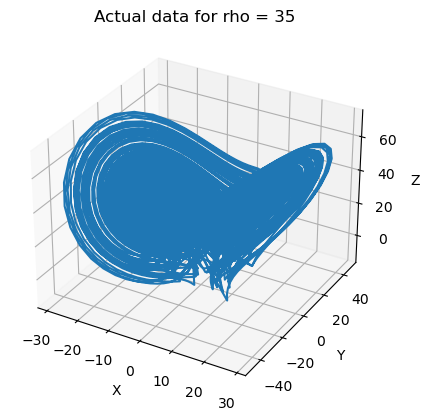

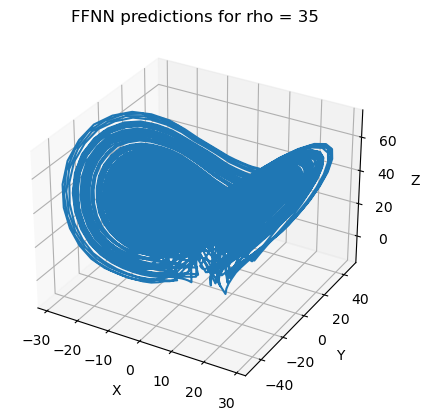

In [63]:
# Generate data for the original Lorenz equations
rho = 35
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the FFNN predictions
x_t = X_test[:-1, :]

# Make FFNN predictions and rescale the data
ffnn_pred = ffnn_model.predict(X_test_scaled)
ffnn_pred_rescaled = scaler.inverse_transform(ffnn_pred)

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the FFNN predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(ffnn_pred_rescaled[:, 0], ffnn_pred_rescaled[:, 1], ffnn_pred_rescaled[:, 2], label='FFNN prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'FFNN predictions for rho = {rho}')

plt.show()


## Compare feed-forward, LSTM, RNN and Echo State Networks for forecasting the dynamics.


In [18]:
rnn_model, _ = train_rnn(X_train_rnn_lstm, y_train_rnn_lstm, X_test_list[0], y_test_list[0])

In [55]:
for rho in rho_test_values:
    X_test, y_test = generate_data(rho)
    print(X_test.shape)

    X_test_scaled = scaler.transform(X_test)
    y_test_scaled = scaler.transform(y_test)
    X_test_rnn_lstm = X_test_scaled.reshape(-1, 1, 3)

    rnn_pred = rnn_model.predict(X_test_rnn_lstm)
    # Calculate Mean Squared Error (MSE) for each model
    rnn_mse = np.mean((y_test_scaled - rnn_pred)**2)

    print(f"Mean Squared Error for rho = {rho}")
    print(f"RNN: {rnn_mse}")

(80000, 3)
2500/2500 [==============================] - 2s 758us/step
Mean Squared Error for rho = 10
RNN: 0.037857085428462924
(80000, 3)
2500/2500 [==============================] - 2s 774us/step
Mean Squared Error for rho = 28
RNN: 0.04218182993158904


2500/2500 [==============================] - 2s 723us/step


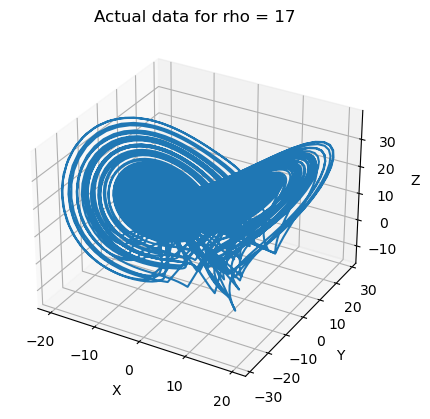

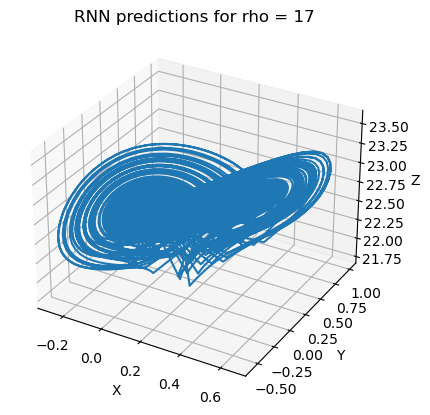

In [57]:
# Generate data for the original Lorenz equations
rho = 17
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the RNN predictions
x_t = X_test[:-1, :]

# Make RNN predictions and rescale the data
X_test_rnn_lstm = X_test_scaled.reshape(-1, 1, 3)
rnn_pred = rnn_model.predict(X_test_rnn_lstm)
rnn_pred_rescaled = scaler.inverse_transform(rnn_pred.reshape(-1, 3))

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the RNN predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(rnn_pred_rescaled[:, 0], rnn_pred_rescaled[:, 1], rnn_pred_rescaled[:, 2], label='RNN prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'RNN predictions for rho = {rho}')

plt.show()


2500/2500 [==============================] - 2s 777us/step


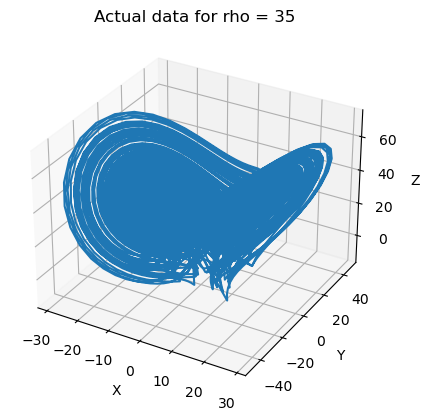

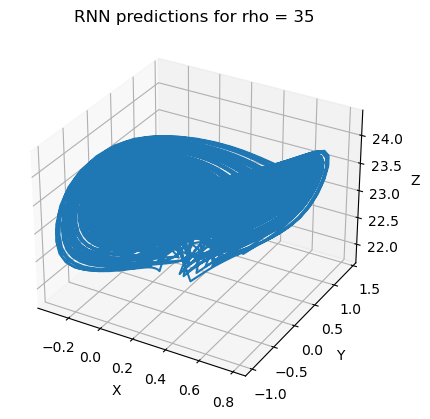

In [64]:
# Generate data for the original Lorenz equations
rho = 35
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the RNN predictions
x_t = X_test[:-1, :]

# Make RNN predictions and rescale the data
X_test_rnn_lstm = X_test_scaled.reshape(-1, 1, 3)
rnn_pred = rnn_model.predict(X_test_rnn_lstm)
rnn_pred_rescaled = scaler.inverse_transform(rnn_pred.reshape(-1, 3))

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the RNN predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(rnn_pred_rescaled[:, 0], rnn_pred_rescaled[:, 1], rnn_pred_rescaled[:, 2], label='RNN prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'RNN predictions for rho = {rho}')

plt.show()


In [22]:
lstm_model, _ = train_lstm(X_train_rnn_lstm, y_train_rnn_lstm, X_test_list[0], y_test_list[0])

In [23]:
for rho in rho_test_values:
    X_test, y_test = generate_data(rho)

    X_test_scaled = scaler.transform(X_test)
    y_test_scaled = scaler.transform(y_test)
    X_test_rnn_lstm = X_test_scaled.reshape(-1, 1, 3)

    lstm_pred = lstm_model.predict(X_test_rnn_lstm)
    # Calculate Mean Squared Error (MSE) for each model
    lstm_mse = np.mean((y_test_scaled - lstm_pred)**2)

    print(f"Mean Squared Error for rho = {rho}")
    print(f"LSTM: {lstm_mse}")

2500/2500 [==============================] - 3s 965us/step
Mean Squared Error for rho = 17
LSTM: 0.030265745313244153
2500/2500 [==============================] - 3s 1ms/step
Mean Squared Error for rho = 35
LSTM: 0.06378890443500634


2500/2500 [==============================] - 2s 982us/step


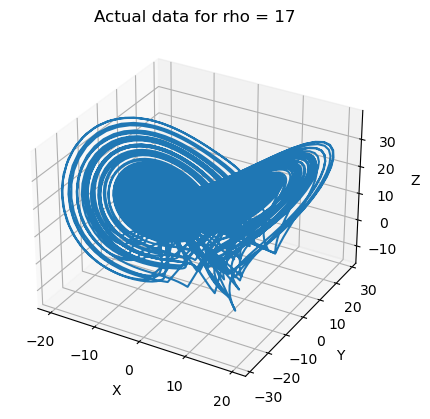

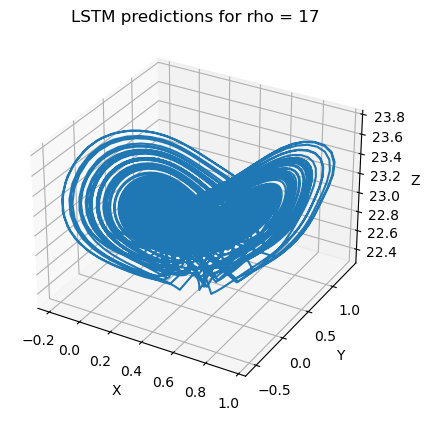

In [58]:
# Generate data for the original Lorenz equations
rho = 17
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the LSTM predictions
x_t = X_test[:-1, :]

# Make LSTM predictions and rescale the data
X_test_rnn_lstm = X_test_scaled.reshape(-1, 1, 3)
lstm_pred = lstm_model.predict(X_test_rnn_lstm)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred.reshape(-1, 3))

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the LSTM predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(lstm_pred_rescaled[:, 0], lstm_pred_rescaled[:, 1], lstm_pred_rescaled[:, 2], label='LSTM prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'LSTM predictions for rho = {rho}')

plt.show()


2500/2500 [==============================] - 3s 1ms/step


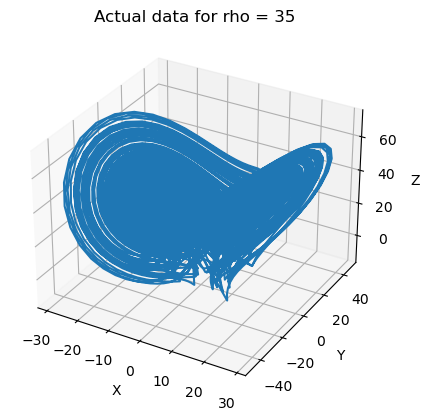

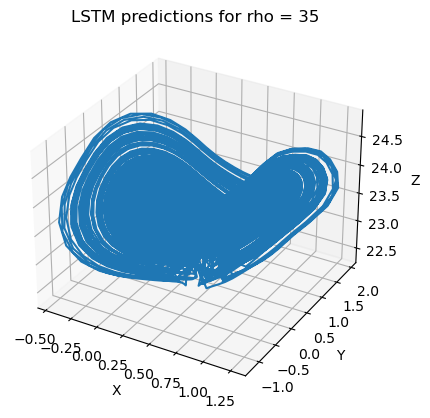

In [65]:
# Generate data for the original Lorenz equations
rho = 35
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the LSTM predictions
x_t = X_test[:-1, :]

# Make LSTM predictions and rescale the data
X_test_rnn_lstm = X_test_scaled.reshape(-1, 1, 3)
lstm_pred = lstm_model.predict(X_test_rnn_lstm)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred.reshape(-1, 3))

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the LSTM predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(lstm_pred_rescaled[:, 0], lstm_pred_rescaled[:, 1], lstm_pred_rescaled[:, 2], label='LSTM prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'LSTM predictions for rho = {rho}')

plt.show()


## Create our ESN model we can use to forecast

In [60]:
#Create our ESN model for comparison
def create_esn_model(input_shape, units, connectivity=0.1, leaky=1, spectral_radius=0.9):
    inputs = tf.keras.Input(shape=input_shape)
    esn_outputs = tfa.layers.ESN(units, connectivity, leaky, spectral_radius)(inputs)
    output = tf.keras.layers.Dense(3)(esn_outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    return model

def train_esn(X_train, y_train, X_test, y_test, input_shape, reservoir_size, epochs=50, batch_size=32):
    esn_model = create_esn_model(input_shape, reservoir_size)
    esn_history = esn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)
    return esn_model, esn_history

In [61]:
y_train_combined_3 = y_train_combined.reshape(-1, 1, 3)
y_test_scaled_3 = y_test_scaled.reshape(-1, 1, 3)

esn_model, esn_history = train_esn(X_train_esn, y_train_combined_3, X_test_esn, y_test_scaled_3, input_shape, reservoir_size)


Epoch 1/50
6750/6750 - 8s - loss: 0.0597 - val_loss: 0.0436 - 8s/epoch - 1ms/step
Epoch 2/50
6750/6750 - 8s - loss: 0.0596 - val_loss: 0.0443 - 8s/epoch - 1ms/step
Epoch 3/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0446 - 9s/epoch - 1ms/step
Epoch 4/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0436 - 9s/epoch - 1ms/step
Epoch 5/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0430 - 9s/epoch - 1ms/step
Epoch 6/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0437 - 9s/epoch - 1ms/step
Epoch 7/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0443 - 9s/epoch - 1ms/step
Epoch 8/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0443 - 9s/epoch - 1ms/step
Epoch 9/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0438 - 9s/epoch - 1ms/step
Epoch 10/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0436 - 9s/epoch - 1ms/step
Epoch 11/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0444 - 9s/epoch - 1ms/step
Epoch 12/50
6750/6750 - 9s - loss: 0.0596 - val_loss: 0.0446 - 9s/epoch - 1ms/step
Epoch 13/50
6

2500/2500 [==============================] - 2s 717us/step


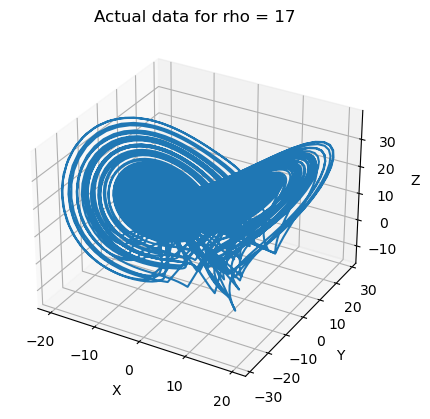

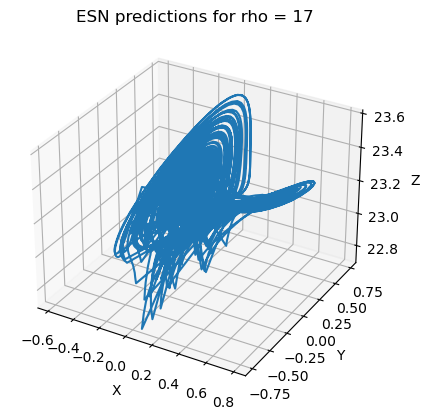

In [62]:
# Generate data for the original Lorenz equations
rho = 17
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the ESN predictions
x_t = X_test[:-1, :]

# Make ESN predictions and rescale the data
X_test_esn = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])
esn_pred = esn_model.predict(X_test_esn)
esn_pred_rescaled = scaler.inverse_transform(esn_pred.reshape(-1, 3))

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the ESN predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(esn_pred_rescaled[:, 0], esn_pred_rescaled[:, 1], esn_pred_rescaled[:, 2], label='ESN prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'ESN predictions for rho = {rho}')

plt.show()


2500/2500 [==============================] - 2s 685us/step


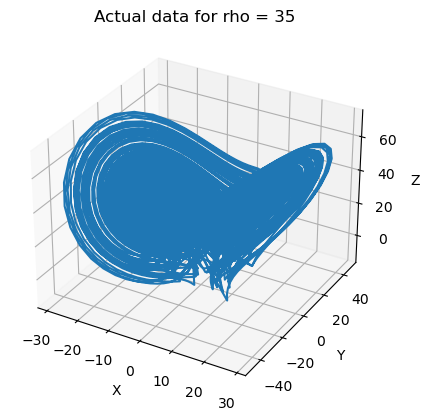

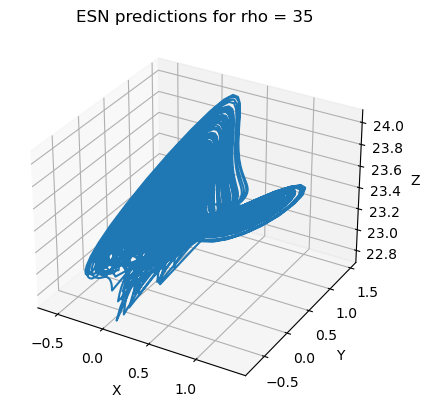

In [66]:
# Generate data for the original Lorenz equations
rho = 35
X_test, y_test = generate_data(rho)
X_test_scaled = scaler.transform(X_test)

# Obtain the original data for the same time period as the ESN predictions
x_t = X_test[:-1, :]

# Make ESN predictions and rescale the data
X_test_esn = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])
esn_pred = esn_model.predict(X_test_esn)
esn_pred_rescaled = scaler.inverse_transform(esn_pred.reshape(-1, 3))

# Create a plot for the actual data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(x_t[:, 0], x_t[:, 1], x_t[:, 2], label='Lorenz equations')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Actual data for rho = {rho}')

# Create a plot for the ESN predictions
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(esn_pred_rescaled[:, 0], esn_pred_rescaled[:, 1], esn_pred_rescaled[:, 2], label='ESN prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'ESN predictions for rho = {rho}')

plt.show()
